In [44]:
import boto3
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [45]:
"""
Transform input data for model
Lowercase all strings in the dataset
One-hot encode categorical columns such as Ethnicity and Gender
Return the one-hot encoder and combined numpy array
"""
def transform_input(df):
    df.applymap(lambda s: s.lower() if type(s) == str else s)
    df = df.drop(['Campus'], axis=1)
    
    # round gpas to the nearest hundreth
    df['GPA'] = [round(gpa, 2) for gpa in df['GPA']]
    
    # round sat scores to the nearest ten
    df['AvgScrRead'] = [round(score, -1) for score in df['AvgScrRead']]
    df['AvgScrMath'] = [round(score, -1) for score in df['AvgScrMath']]
    df['AvgScrWrit'] = [round(score, -1) for score in df['AvgScrWrit']]

    encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
    categorical_cols = ['Ethnicity', 'Gender', 'County']
    categorical = df[categorical_cols].values

    non_categorical_cols = ['GPA', 'AvgScrRead', 'AvgScrMath', 'AvgScrWrit']
    intermediate = df[non_categorical_cols]

    categoricl_transformed = encoder.fit_transform(categorical).toarray()
    features = np.hstack((intermediate.values, categoricl_transformed))

    return encoder, features

#### Read data

In [54]:
df = pd.read_csv('../data/applicant_admissions_data.csv')
df = df[df['Status'] == 1]

#### Look at some counts

In [55]:
# how many admits per campus?
df.groupby('Campus') \
    .count() \
    .reset_index()[['Campus', 'County']] \
    .rename(columns={'County': 'Number of Admits'})

,Campus,Number of Admits
0,Berkeley,409
1,Davis,448
2,Irvine,409
3,Los Angeles,409
4,Merced,421
5,Riverside,409
6,San Diego,424
7,Santa Barbara,439
8,Santa Cruz,448
9,Universitywide,454


In [56]:
# how many admits per county?
df.groupby('County') \
    .count() \
    .reset_index()[['Campus', 'County']] \
    .rename(columns={'Campus': 'Number of Admits'})

,Number of Admits,County
0,320,Alameda
1,150,Amador
2,320,Contra Costa
3,90,Humboldt
4,320,Los Angeles
5,48,Mendocino
6,150,Monterey
7,150,Napa
8,320,Orange
9,150,Sacramento


In [57]:
# how many admits per ethnicity?
df.groupby('Ethnicity') \
    .count() \
    .reset_index()[['Ethnicity', 'County']] \
    .rename(columns={'County': 'Number of Admits'})

,Ethnicity,Number of Admits
0,African American,520
1,All,685
2,American Indian,272
3,Asian,652
4,Domestic Unknown,577
5,Hispanic/ Latino,649
6,Inter- national,260
7,White,655


In [47]:
df = df.drop(['Unnamed: 0', 'Status'], axis=1)
df.head()

,County,Ethnicity,Gender,Campus,GPA,AvgScrRead,AvgScrMath,AvgScrWrit
0,San Bernardino,Domestic Unknown,Male,Berkeley,4.134665,462.0,470.0,453.0
1,San Bernardino,Domestic Unknown,Male,Davis,3.969556,462.0,470.0,453.0
2,San Bernardino,Domestic Unknown,Male,Irvine,3.966652,462.0,470.0,453.0
3,San Bernardino,Domestic Unknown,Male,Los Angeles,4.131310,462.0,470.0,453.0
4,San Bernardino,Domestic Unknown,Male,Merced,3.523493,462.0,470.0,453.0


#### Transform data

In [48]:
# transform the data for the model
# return the encoder as it is used in predictions
encoder, X = transform_input(df)

print ("X dimensions {0}".format(X.shape))

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Campus'])

print ("y dimensions {0}".format(y.shape))

# split data into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ("X train dimensions {0}".format(X_train.shape))
print ("y train dimensions {0}".format(y_train.shape))

X dimensions (4270, 39)
y dimensions (4270,)
X train dimensions (3416, 39)
y train dimensions (3416,)


#### Train the model

predicted dimensions (854,)
y test dimensions (854,)


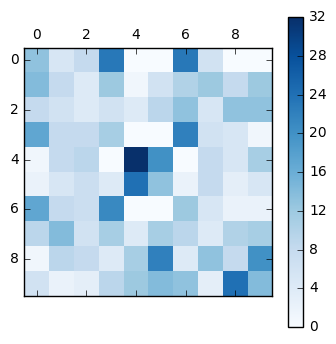

In [49]:
# train model
clf = LogisticRegression(
    random_state=0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=500)

clf.fit(X_train, y_train)

# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

# train model
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print ("predicted dimensions {0}".format(y_pred.shape))
print ("y test dimensions {0}".format(y_test.shape))

cm = confusion_matrix(y_test, y_pred)

# Plot pixel ranking
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [50]:
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Write data to Amazon S3

In [51]:
# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

In [52]:
s3 = boto3.client('s3')
s3.upload_file('models/gosat_logistic_regression', 'gosat-models', 'gosat_logistic_regression')
s3.upload_file('models/gosat_logistic_encoder', 'gosat-models', 'gosat_logistic_encoder')

In [53]:
# output mapping of labels to universities
mapping = {}
for index, uni in zip(clf.classes_, le.inverse_transform(clf.classes_)):
    mapping[index] = uni

json.dump(mapping, open('models/label_mappings.json', 'w'))
s3.upload_file('models/label_mappings.json', 'gosat-models', 'gosat_label_mapping.json')